## Imports

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import gymnasium as gym
from diffuser.utils.config import Config
import os
import collections
import numpy as np
import pdb
from minari import DataCollector, StepDataCallback

## Diffuser Lib

In [5]:
class Args:
    def __init__(
        self,
        loader,
        savepath,
        dataset,
        horizon,
        normalizer,
        preprocess_fns,
        use_padding,
        max_path_length,
        renderer,
        model,
        dim_mults,
        device,
    ):
        self.loader = loader
        self.savepath = savepath
        self.dataset = dataset
        self.horizon = horizon
        self.normalizer = normalizer
        self.preprocess_fns = preprocess_fns
        self.use_padding = use_padding
        self.max_path_length = max_path_length
        self.renderer = renderer
        self.model = model
        # self.transition_dim=transition_dim
        # self.cond_dim=cond_dim
        self.dim_mults = dim_mults
        self.device = device


args = Args(
    loader="datasets.sequence.GoalDataset",
    savepath="saved/",
    dataset="",
    horizon=256,
    normalizer="LimitsNormalizer",
    preprocess_fns=["maze2d_set_terminals"],
    use_padding=False,
    max_path_length=10000,
    renderer="utils.rendering.Maze2dRenderer",
    model="models.temporal.TemporalUnet",
    dim_mults=(1, 4, 8),
    device="cpu",
)

In [6]:
dataset_config = Config(
    args.loader,
    savepath=(args.savepath, "dataset_config.pkl"),
    env="PointMaze_Medium-v3",
    horizon=args.horizon,
    normalizer=args.normalizer,
    preprocess_fns=args.preprocess_fns,
    use_padding=args.use_padding,
    max_path_length=args.max_path_length,
)

_class:datasets.sequence.GoalDataset
[ utils/config ] Imported diffuser.datasets.sequence:GoalDataset

[utils/config ] Config: <class 'diffuser.datasets.sequence.GoalDataset'>
    env: PointMaze_Medium-v3
    horizon: 256
    max_path_length: 10000
    normalizer: LimitsNormalizer
    preprocess_fns: ['maze2d_set_terminals']
    use_padding: False

[ utils/config ] Saved config to: saved/dataset_config.pkl



In [7]:
from minari import DataCollector, list_local_datasets, load_dataset, delete_dataset
for dataset_name in list_local_datasets():
    print(dataset_name)
    delete_dataset(dataset_name)



C:\Users\Beste Aydemir\.minari\datasets\pointmaze-umaze-v0\data
pointmaze-umaze-v0
pointmaze-umaze-v0
Dataset pointmaze-umaze-v0 deleted!


In [8]:
dataset = dataset_config()

Name of the enviornment: PointMaze_Medium-v3
Name of the enviornment: PointMaze_Medium-v3
Dataset_name:pointmaze-umaze-v0


c:\Users\Beste Aydemir\AppData\Local\pypoetry\Cache\virtualenvs\adlr-uQXv-DS1-py3.10\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.maze to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.maze` for environment variables or `env.get_wrapper_attr('maze')` that will search the reminding wrappers.
  logger.warn(
c:\Users\Beste Aydemir\AppData\Local\pypoetry\Cache\virtualenvs\adlr-uQXv-DS1-py3.10\lib\site-packages\minari\utils.py:394: UserWarning: `minari_version` is set to None. The compatible dataset version specifier for Minari will be set to ~=0.4.
  warnings.warn(
c:\Users\Beste Aydemir\AppData\Local\pypoetry\Cache\virtualenvs\adlr-uQXv-DS1-py3.10\lib\site-packages\minari\utils.py:414: UserWarning: `eval_env` is set to None. If another environment is intended to be used for evaluation please specify corresponding Gymnasium environment (gym.Env | gym.envs.registration.EnvSpec).              If N

10000
[ datasets/buffer ] Finalized replay buffer | 1 episodes
[ datasets/buffer ] Fields:
    achieved_goal: (1, 10000, 2)
    desired_goal: (1, 10000, 2)
    observations: (1, 10000, 4)
    observation: (1, 10000, 4)
    next_observations: (1, 10000, 4)
    actions: (1, 10000, 2)
    terminals: (1, 10000, 1)
    timeouts: (1, 10000, 1)
[ datasets/buffer ] Fields:
    achieved_goal: (1, 10000, 2)
    desired_goal: (1, 10000, 2)
    observations: (1, 10000, 4)
    observation: (1, 10000, 4)
    next_observations: (1, 10000, 4)
    actions: (1, 10000, 2)
    terminals: (1, 10000, 1)
    timeouts: (1, 10000, 1)
    normed_observations: (1, 10000, 4)
    normed_actions: (1, 10000, 2)


In [9]:
# dataset[1]
# dataset[1].observations["observation"][:, :2]
# dataset[1].total_steps
# env = gym.make("PointMaze_Large-v3")
# env._max_episode_steps
# # env.target
# np.array(wrapped_env.observation_space["desired_goal"])

## Configs for Rendering and the model

In [10]:
render_config = Config(
    args.renderer,
    savepath=(args.savepath, "render_config.pkl"),
    env="PointMaze_Medium-v3",
)

_class:utils.rendering.Maze2dRenderer
[ utils/config ] Imported diffuser.utils.rendering:Maze2dRenderer

[utils/config ] Config: <class 'diffuser.utils.rendering.Maze2dRenderer'>
    env: PointMaze_Medium-v3

[ utils/config ] Saved config to: saved/render_config.pkl



In [11]:
# observation_dim = dataset.observation_dim
# action_dim = dataset.action_dim
observation_dim = 4
action_dim = 2
# -----------------------------------------------------------------------------#
# ------------------------------ model & trainer ------------------------------#
# -----------------------------------------------------------------------------#

model_config = Config(
    args.model,
    savepath=(args.savepath, "model_config.pkl"),
    horizon=args.horizon,
    transition_dim=observation_dim + action_dim,
    cond_dim=observation_dim,
    dim_mults=args.dim_mults,
    device=args.device,
)

_class:models.temporal.TemporalUnet
[ utils/config ] Imported diffuser.models.temporal:TemporalUnet

[utils/config ] Config: <class 'diffuser.models.temporal.TemporalUnet'>
    cond_dim: 4
    dim_mults: (1, 4, 8)
    horizon: 256
    transition_dim: 6

[ utils/config ] Saved config to: saved/model_config.pkl



In [12]:
renderer = render_config()

Name of the enviornment: PointMaze_Medium-v3
[[0 0]]
[ 1.29667893 -0.4399072 ]


In [13]:
model = model_config()

[ models/temporal ] Channel dimensions: [(6, 32), (32, 128), (128, 256)]
[(6, 32), (32, 128), (128, 256)]


In [14]:
diffusion_config = Config(
    _class="models.diffuser.GaussianDiffusion",
    savepath=(args.savepath, "diffusion_config.pkl"),
    horizon=256,
    observation_dim=observation_dim,
    action_dim=2,
    n_timesteps=256,
    loss_type="l2",
    clip_denoised=True,
    predict_epsilon=False,
    # loss weighting
    action_weight=1,
    loss_weights=None,
    loss_discount=1,
    device=args.device,
)

_class:models.diffuser.GaussianDiffusion
[ utils/config ] Imported diffuser.models.diffuser:GaussianDiffusion

[utils/config ] Config: <class 'diffuser.models.diffuser.GaussianDiffusion'>
    action_dim: 2
    action_weight: 1
    clip_denoised: True
    horizon: 256
    loss_discount: 1
    loss_type: l2
    loss_weights: None
    n_timesteps: 256
    observation_dim: 4
    predict_epsilon: False

[ utils/config ] Saved config to: saved/diffusion_config.pkl



In [15]:
diffuser = diffusion_config(model)

## Forward pass is working

In [16]:
from diffuser.utils.arrays import report_parameters, batchify

report_parameters(model)

print("Testing forward...", end=" ", flush=True)
batch = batchify(dataset[0])
loss, _ = diffuser.loss(*batch)
loss.backward()
print("✓")

[ utils/arrays ] Total parameters: 3.68 M
         downs.2.0.blocks.1.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         downs.2.1.blocks.0.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         downs.2.1.blocks.1.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         ups.0.0.blocks.0.block.0.weight: 327.68 k | Conv1d(512, 128, kernel_size=(5,), stride=(1,), padding=(2,))
         mid_block1.blocks.0.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         mid_block1.blocks.1.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         mid_block2.blocks.0.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         mid_block2.blocks.1.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         downs.2.0.b

## Using the trainer requires taking care of the 'device' in the folders

In [23]:
from diffuser.utils.training import Trainer

trainer_config = Config(
    Trainer,
    savepath=(args.savepath, "trainer_config.pkl"),
    train_batch_size=32,
    train_lr=2e-4,
    gradient_accumulate_every=2,
    ema_decay=0.005,
    sample_freq=10,
    save_freq=50,
    label_freq=int(2e4 // 50),
    save_parallel=False,
    results_folder=args.savepath,
    bucket=None,
    n_reference=1,
    n_samples=1,
)


[utils/config ] Config: <class 'diffuser.utils.training.Trainer'>
    bucket: None
    ema_decay: 0.005
    gradient_accumulate_every: 2
    label_freq: 400
    n_reference: 1
    n_samples: 1
    results_folder: saved/
    sample_freq: 10
    save_freq: 50
    save_parallel: False
    train_batch_size: 32
    train_lr: 0.0002

[ utils/config ] Saved config to: saved/trainer_config.pkl



In [24]:
trainer = trainer_config(diffuser, dataset, renderer)

# Training process inlcluding rendering

In [19]:
import torch

torch.cuda.is_available()

False

Epoch 0 / 1 | saved/
[ utils/training ] Saved model to saved/state_0.pt
300:   0.0322 | a0_loss:   0.2095 | t:   2.4771
Step: 300 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7203844   2.3562407   0.05395794  0.17659605]


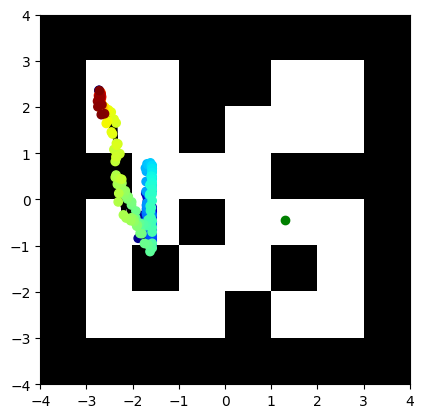

Saved 1 samples to: saved/sample-300-0.png
(1, 257, 4)
1
The last observation [-2.7118213   2.348689    0.12806463  0.21884716]


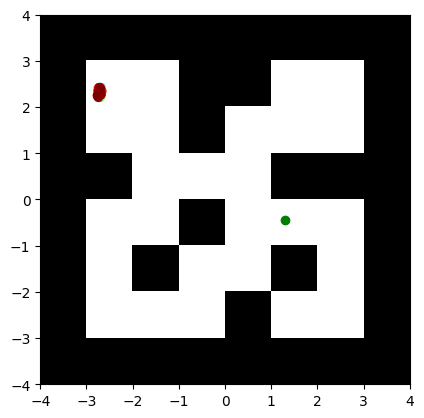

Saved 1 samples to: saved/sample-300-1.png
Step: 310 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7458787  2.3588114 -0.3307724  0.0404259]


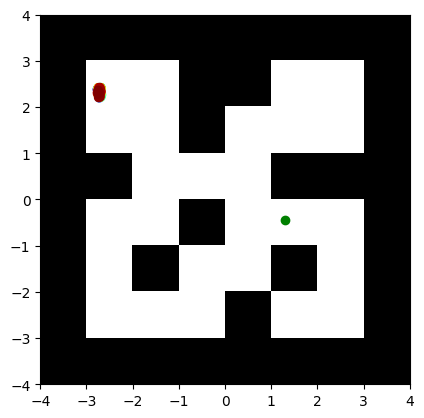

Saved 1 samples to: saved/sample-310-0.png
(1, 257, 4)
1
The last observation [-2.7346919   2.3645215   0.3002081   0.04267442]


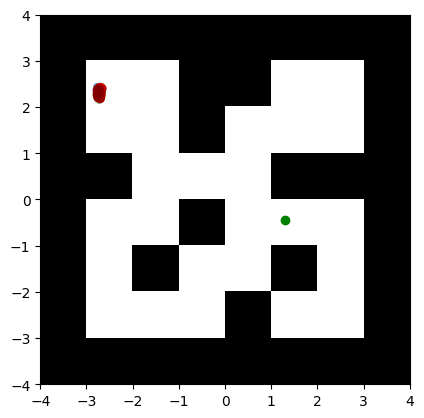

Saved 1 samples to: saved/sample-310-1.png
Step: 320 - Rendering samples
(1, 257, 4)
1
The last observation [-2.713048    2.353046    0.12040281 -0.12589705]


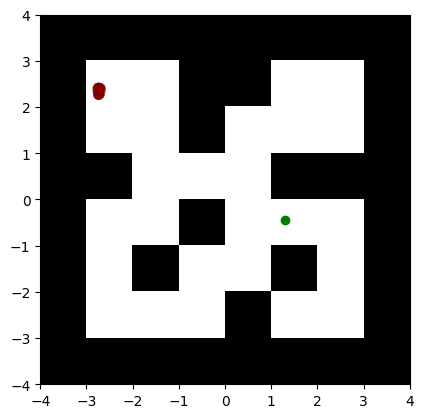

Saved 1 samples to: saved/sample-320-0.png
(1, 257, 4)
1
The last observation [-2.702431    2.366938    0.22946167  0.11713636]


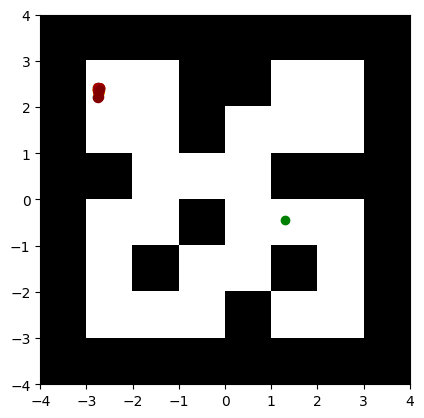

Saved 1 samples to: saved/sample-320-1.png
Step: 330 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7225978  2.3648453 -0.3041737  0.2894708]


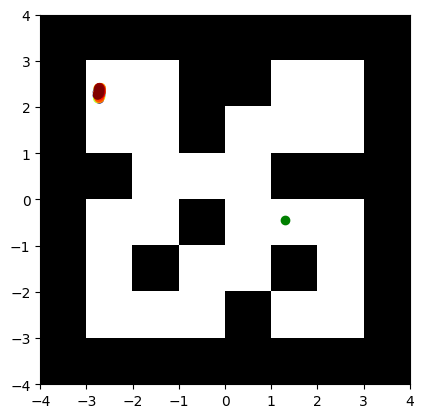

Saved 1 samples to: saved/sample-330-0.png
(1, 257, 4)
1
The last observation [-2.7263725   2.374557   -0.38485956 -0.1391648 ]


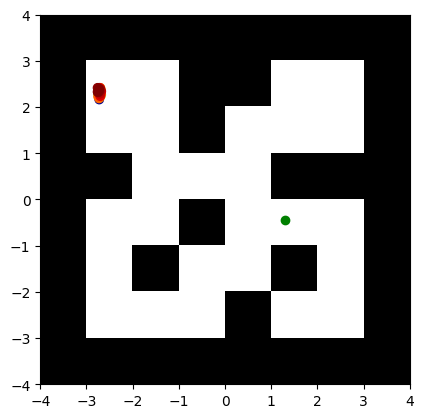

Saved 1 samples to: saved/sample-330-1.png
Step: 340 - Rendering samples
(1, 257, 4)
1
The last observation [-2.724034    2.3495483   0.12447786  0.0717212 ]


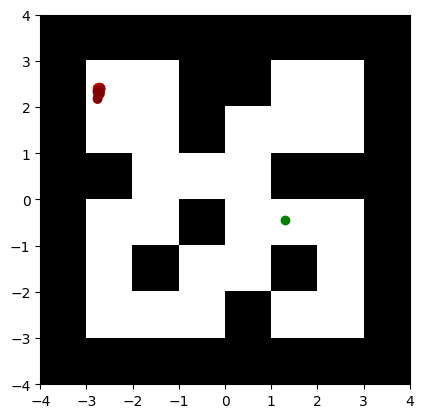

Saved 1 samples to: saved/sample-340-0.png
(1, 257, 4)
1
The last observation [-2.7047958e+00  2.3559704e+00 -8.3368778e-02  2.1300316e-03]


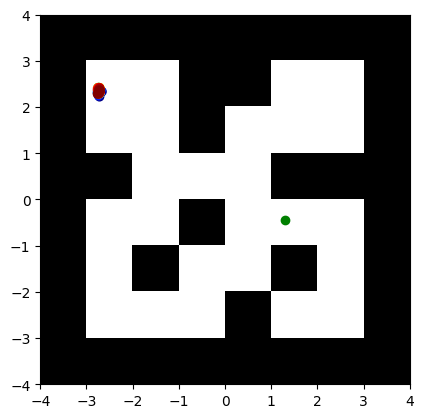

Saved 1 samples to: saved/sample-340-1.png
[ utils/training ] Saved model to saved/state_0.pt
Step: 350 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7288299   2.3475895  -0.12156534 -0.0672133 ]


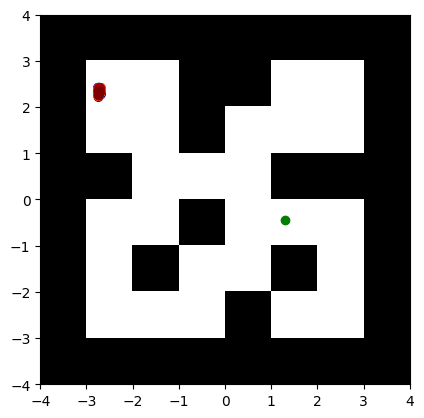

Saved 1 samples to: saved/sample-350-0.png
(1, 257, 4)
1
The last observation [-2.7147248   2.3554482  -0.15080452 -0.05494237]


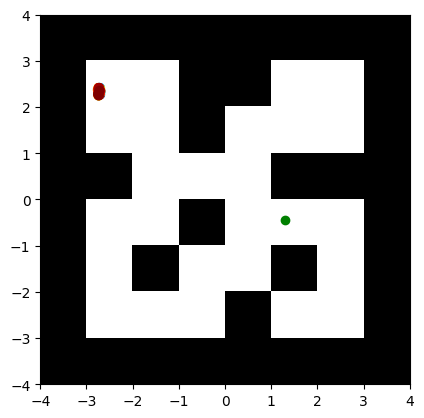

Saved 1 samples to: saved/sample-350-1.png
Step: 360 - Rendering samples
(1, 257, 4)
1
The last observation [-2.717107    2.3607688   0.11165905  0.18209708]


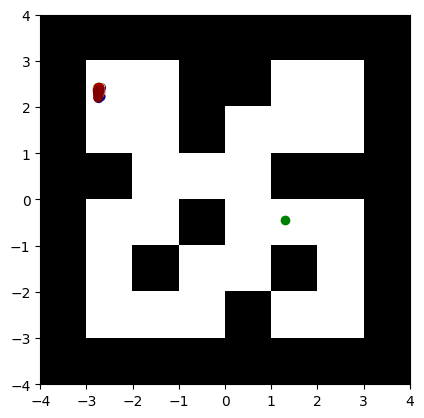

Saved 1 samples to: saved/sample-360-0.png
(1, 257, 4)
1
The last observation [-2.7209344   2.364595    0.13166523 -0.16108167]


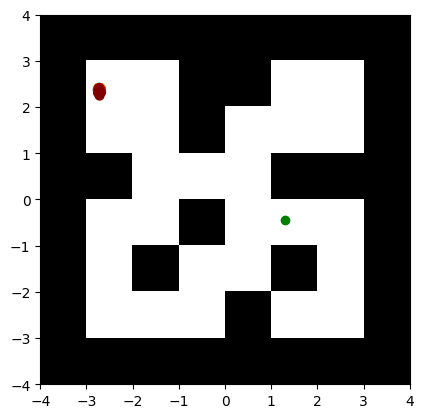

Saved 1 samples to: saved/sample-360-1.png
Step: 370 - Rendering samples
(1, 257, 4)
1
The last observation [-2.729263    2.363698    0.28918266  0.14243972]


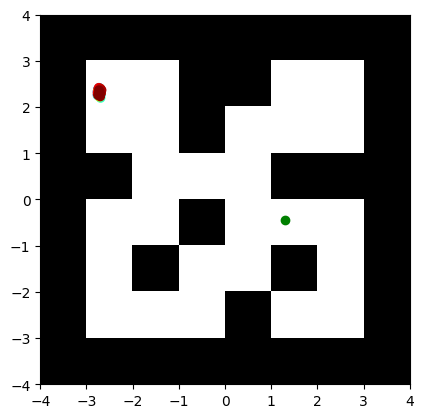

Saved 1 samples to: saved/sample-370-0.png
(1, 257, 4)
1
The last observation [-2.718928    2.3553238  -0.1598978   0.19262373]


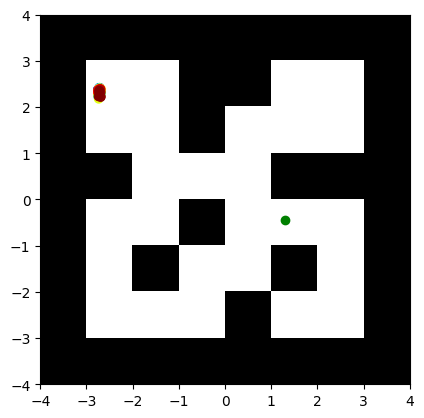

Saved 1 samples to: saved/sample-370-1.png
Step: 380 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7135646   2.3538914  -0.17356014 -0.00421286]


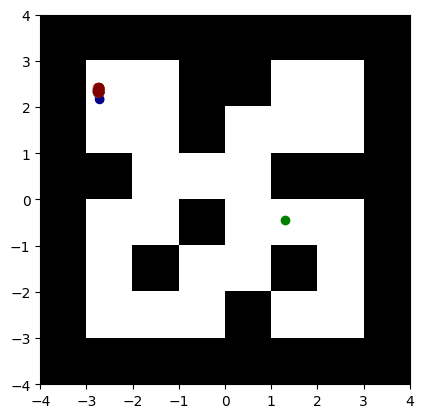

Saved 1 samples to: saved/sample-380-0.png
(1, 257, 4)
1
The last observation [-2.7218013   2.3612013  -0.15748358  0.13586628]


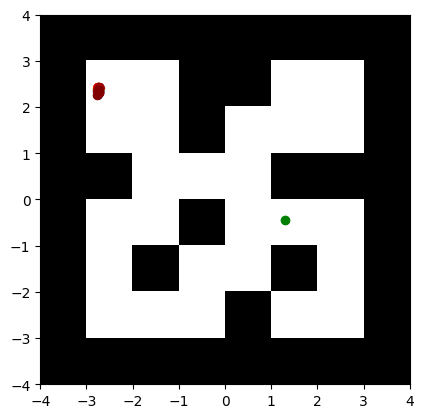

Saved 1 samples to: saved/sample-380-1.png
Step: 390 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7323403   2.3693376   0.04200602  0.25679862]


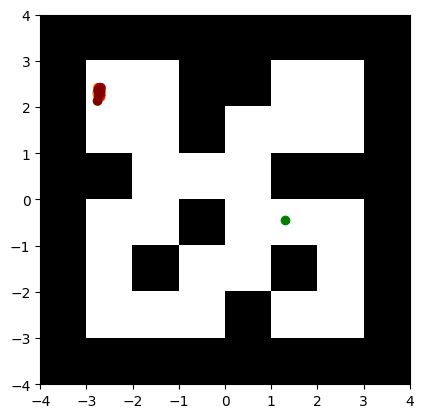

Saved 1 samples to: saved/sample-390-0.png
(1, 257, 4)
1
The last observation [-2.70822     2.3706427   0.10481215 -0.1528877 ]


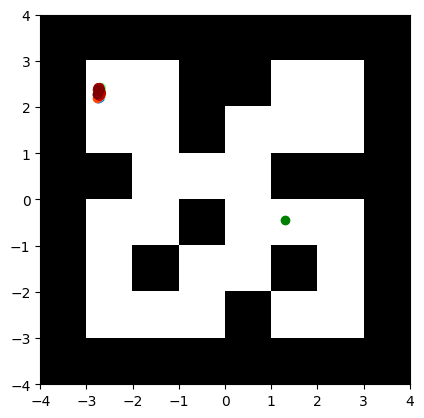

Saved 1 samples to: saved/sample-390-1.png
[ utils/training ] Saved model to saved/state_400.pt
400:   0.0293 | a0_loss:   0.2531 | t: 731.5054
Step: 400 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7339575   2.3570971   0.31940174 -0.02551055]


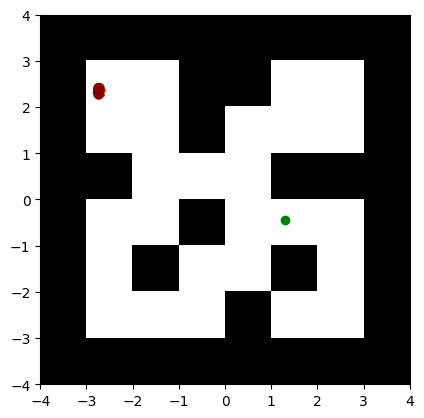

Saved 1 samples to: saved/sample-400-0.png
(1, 257, 4)
1
The last observation [-2.728959    2.3696585  -0.0191555   0.00763237]


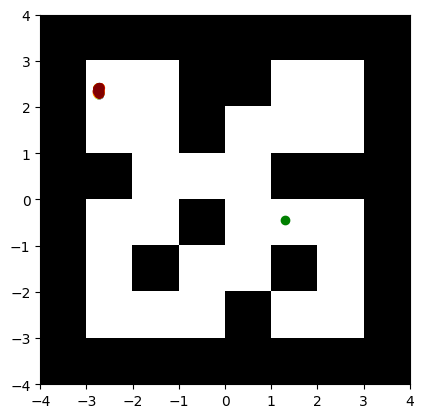

Saved 1 samples to: saved/sample-400-1.png
Step: 410 - Rendering samples
(1, 257, 4)
1
The last observation [-2.713639    2.3679705   0.08579254  0.00783134]


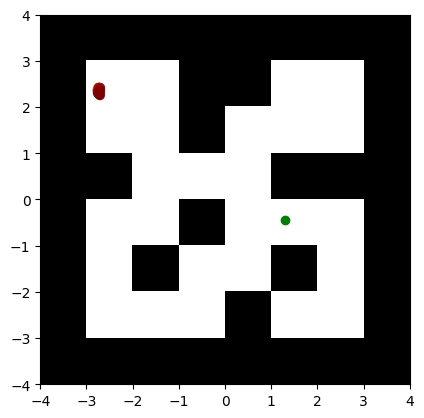

Saved 1 samples to: saved/sample-410-0.png
(1, 257, 4)
1
The last observation [-2.73453     2.381215   -0.24388051 -0.16704786]


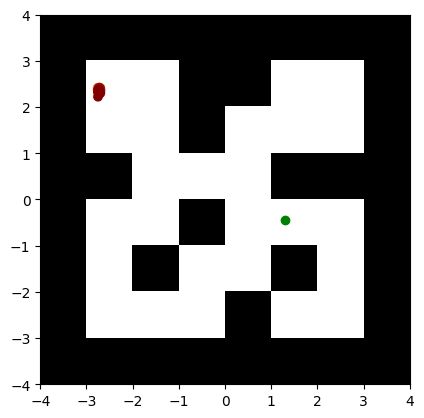

Saved 1 samples to: saved/sample-410-1.png
Step: 420 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7209644  2.3546543 -0.561744  -0.2684132]


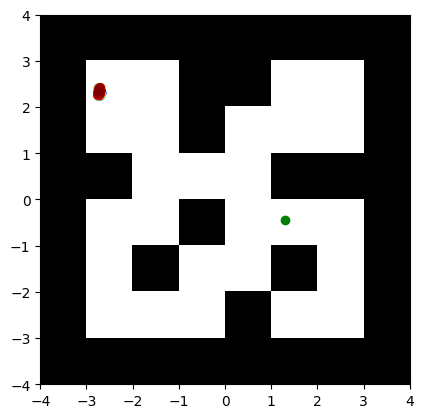

Saved 1 samples to: saved/sample-420-0.png
(1, 257, 4)
1
The last observation [-2.711989   2.3349452  0.0432744  0.1014291]


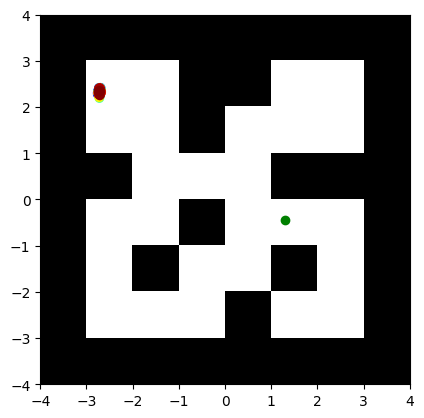

Saved 1 samples to: saved/sample-420-1.png
Step: 430 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7095907   2.3450956   0.11820173 -0.07181549]


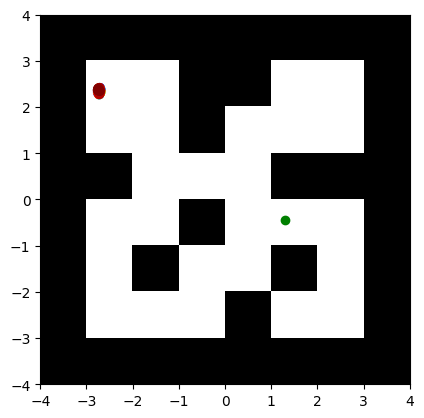

Saved 1 samples to: saved/sample-430-0.png
(1, 257, 4)
1
The last observation [-2.7144125   2.3692298   0.01869249  0.02521765]


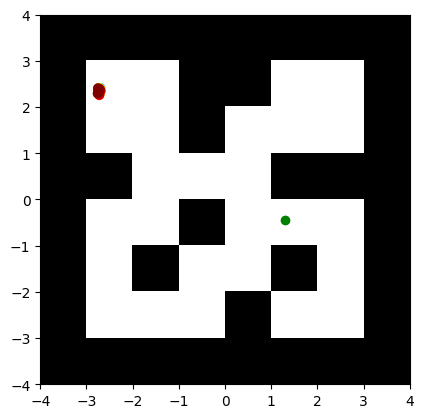

Saved 1 samples to: saved/sample-430-1.png
Step: 440 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7261992   2.3549023   0.0952487   0.00886583]


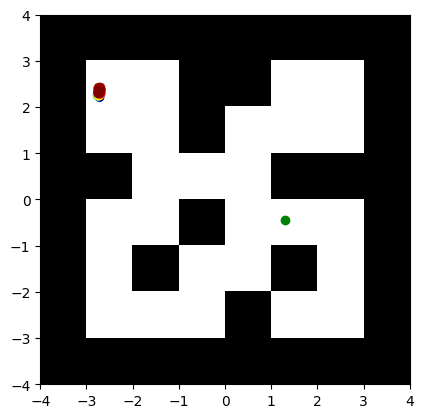

Saved 1 samples to: saved/sample-440-0.png
(1, 257, 4)
1
The last observation [-2.7339602   2.3503046   0.31359243 -0.079638  ]


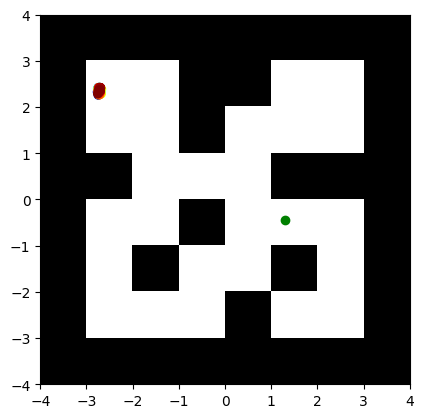

Saved 1 samples to: saved/sample-440-1.png
[ utils/training ] Saved model to saved/state_400.pt
Step: 450 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7299113   2.3734756   0.12377644 -0.347018  ]


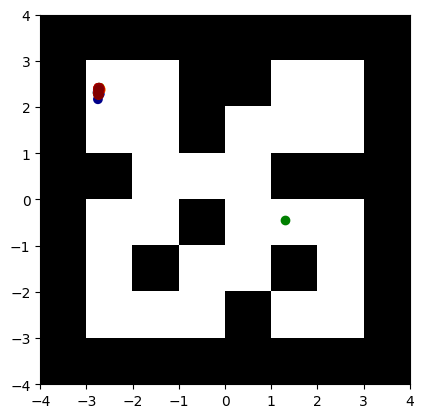

Saved 1 samples to: saved/sample-450-0.png
(1, 257, 4)
1
The last observation [-2.718427    2.3592343  -0.04848385 -0.09132481]


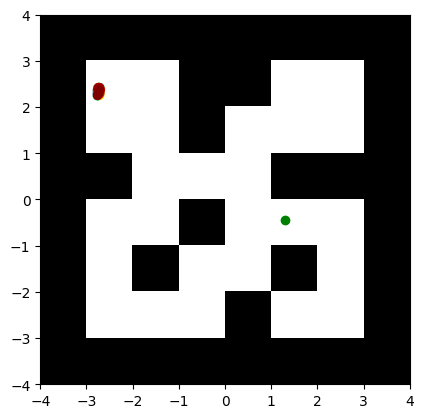

Saved 1 samples to: saved/sample-450-1.png
Step: 460 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7214081   2.3607783  -0.23740816  0.03818285]


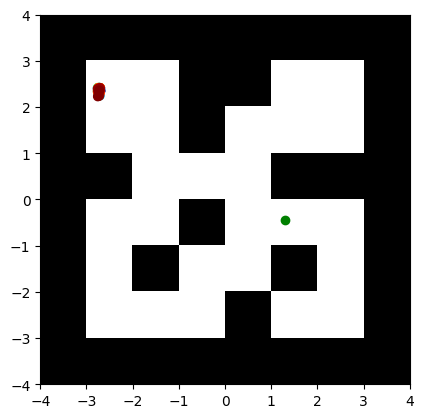

Saved 1 samples to: saved/sample-460-0.png
(1, 257, 4)
1
The last observation [-2.718968    2.3487067   0.05156755 -0.10363841]


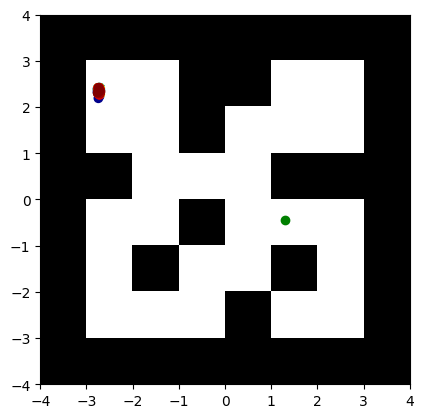

Saved 1 samples to: saved/sample-460-1.png
Step: 470 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7380054   2.3744283  -0.08433533 -0.10108018]


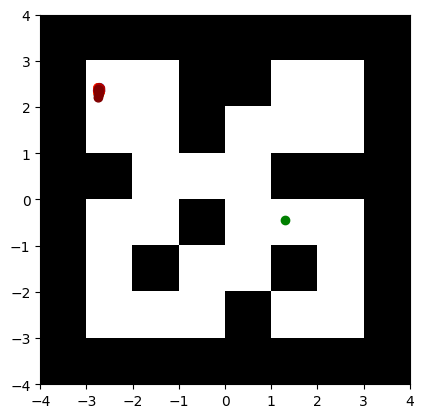

Saved 1 samples to: saved/sample-470-0.png
(1, 257, 4)
1
The last observation [-2.7352912   2.361703   -0.10183764 -0.05915368]


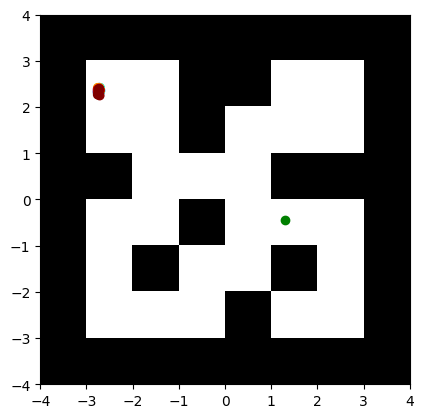

Saved 1 samples to: saved/sample-470-1.png
Step: 480 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7133543   2.3666463   0.05110216  0.02285469]


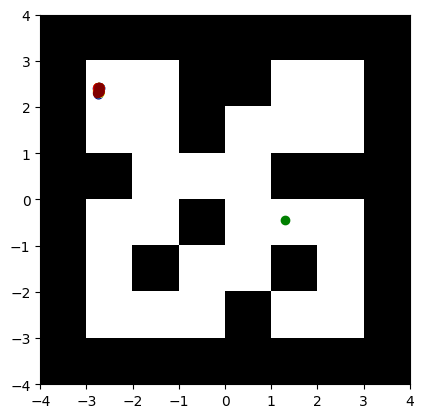

Saved 1 samples to: saved/sample-480-0.png
(1, 257, 4)
1
The last observation [-2.717569    2.34102     0.1175127  -0.15984285]


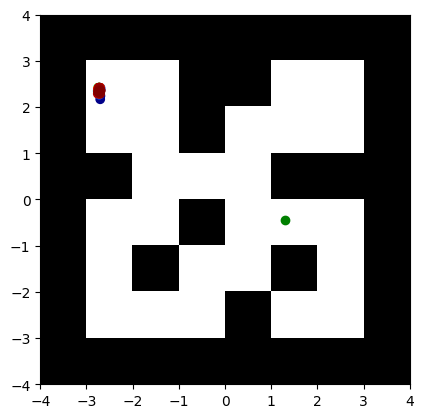

Saved 1 samples to: saved/sample-480-1.png
Step: 490 - Rendering samples
(1, 257, 4)
1
The last observation [-2.709035    2.3569307  -0.18930483 -0.4456433 ]


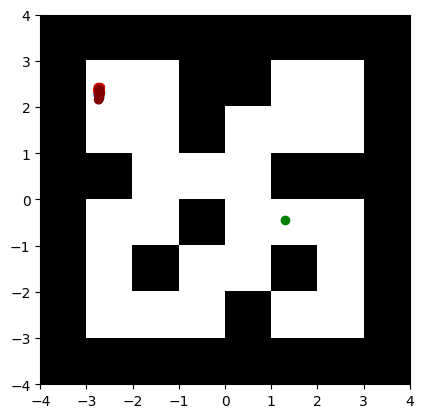

Saved 1 samples to: saved/sample-490-0.png
(1, 257, 4)
1
The last observation [-2.740297    2.3564215   0.03426552  0.0041337 ]


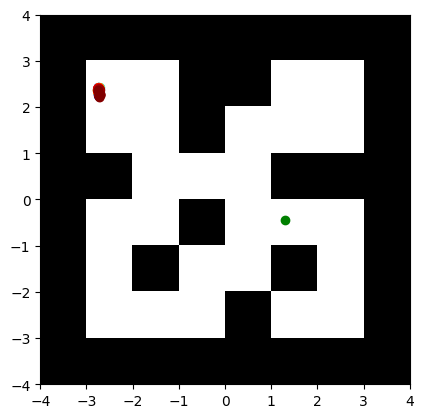

Saved 1 samples to: saved/sample-490-1.png
[ utils/training ] Saved model to saved/state_400.pt
500:   0.0313 | a0_loss:   0.2361 | t: 794.0470
Step: 500 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7152665   2.3563867   0.0326786   0.15385878]


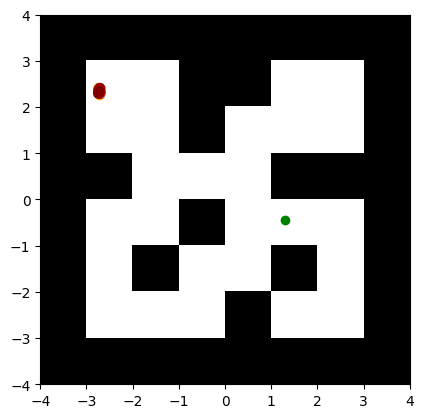

Saved 1 samples to: saved/sample-500-0.png
(1, 257, 4)
1
The last observation [-2.732421    2.3615527   0.07302094 -0.30862522]


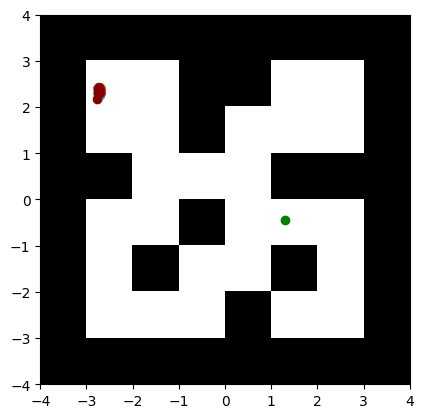

Saved 1 samples to: saved/sample-500-1.png
Step: 510 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7206452   2.3716393  -0.24170637  0.17546761]


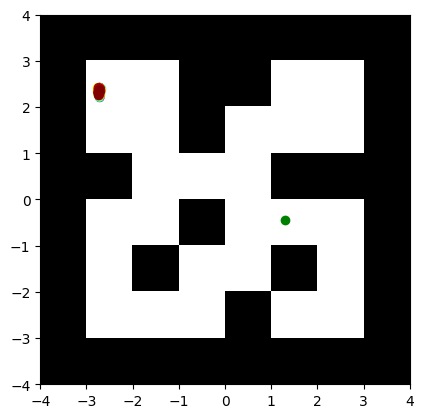

Saved 1 samples to: saved/sample-510-0.png
(1, 257, 4)
1
The last observation [-2.71666     2.3398585  -0.00315762 -0.45132375]


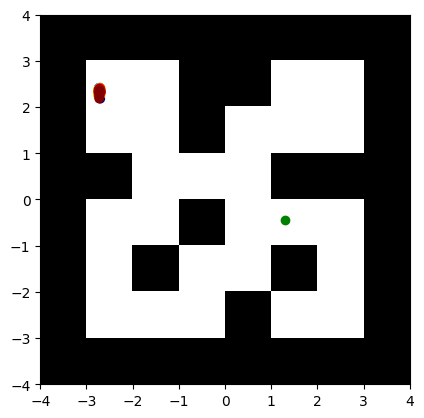

Saved 1 samples to: saved/sample-510-1.png
Step: 520 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7225068   2.338922   -0.00512457 -0.15235579]


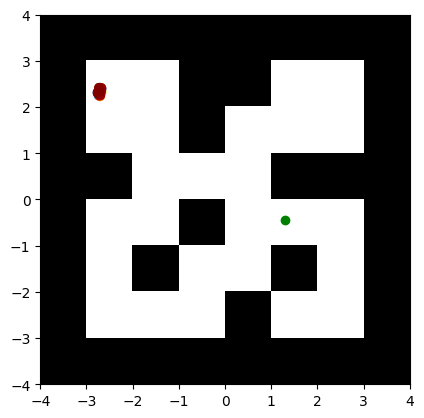

Saved 1 samples to: saved/sample-520-0.png
(1, 257, 4)
1
The last observation [-2.7342706   2.354792   -0.11534405 -0.14086354]


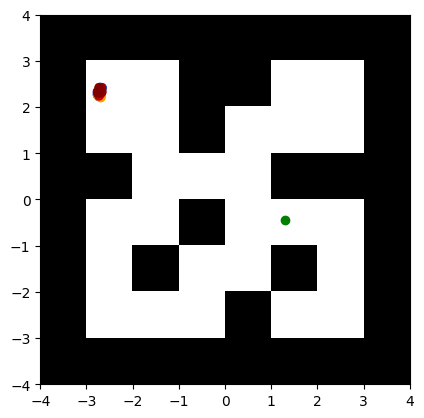

Saved 1 samples to: saved/sample-520-1.png
Step: 530 - Rendering samples
(1, 257, 4)
1
The last observation [-2.735014    2.3298602   0.06262302 -0.29846394]


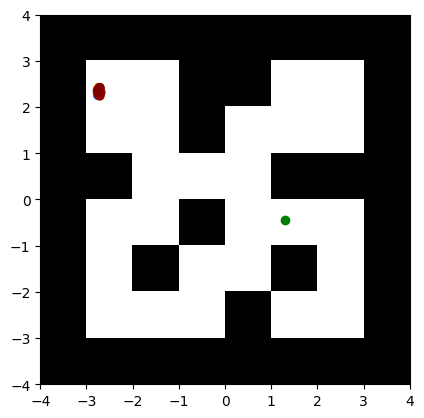

Saved 1 samples to: saved/sample-530-0.png
(1, 257, 4)
1
The last observation [-2.7215574   2.3320565   0.2578721   0.08352506]


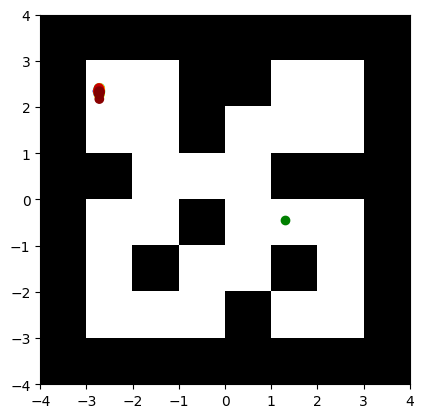

Saved 1 samples to: saved/sample-530-1.png
Step: 540 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7254646   2.3454618   0.25152874 -0.09346676]


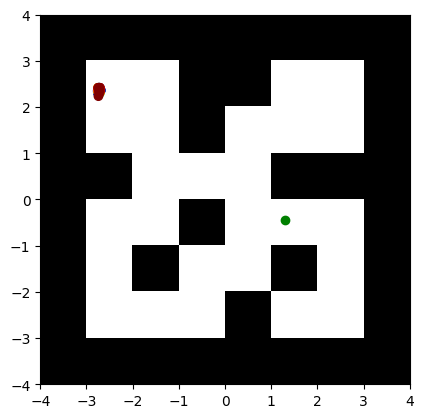

Saved 1 samples to: saved/sample-540-0.png
(1, 257, 4)
1
The last observation [-2.7283633   2.3531632  -0.17555332  0.05227506]


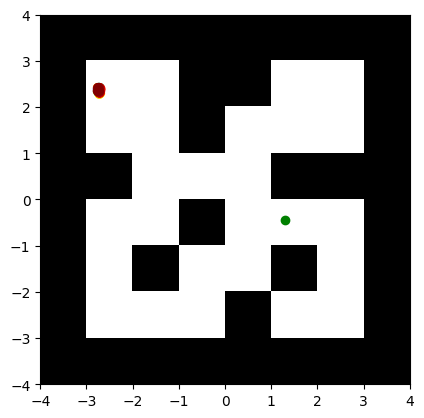

Saved 1 samples to: saved/sample-540-1.png
[ utils/training ] Saved model to saved/state_400.pt
Step: 550 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7060497   2.3799329   0.01705408 -0.27776814]


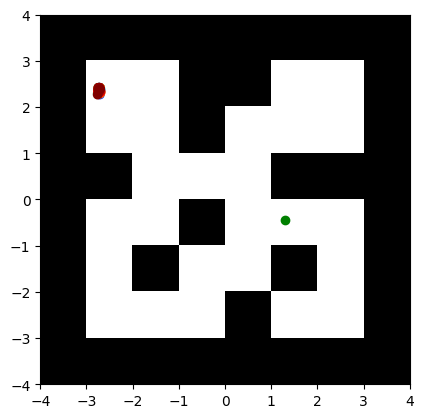

Saved 1 samples to: saved/sample-550-0.png
(1, 257, 4)
1
The last observation [-2.7179315   2.3601732   0.11744022  0.20498788]


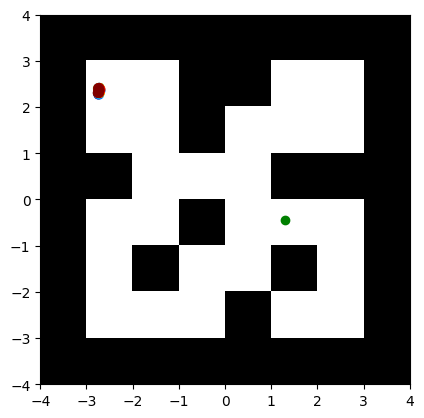

Saved 1 samples to: saved/sample-550-1.png
Step: 560 - Rendering samples
(1, 257, 4)
1
The last observation [-2.735756    2.3507233  -0.19122028  0.06131136]


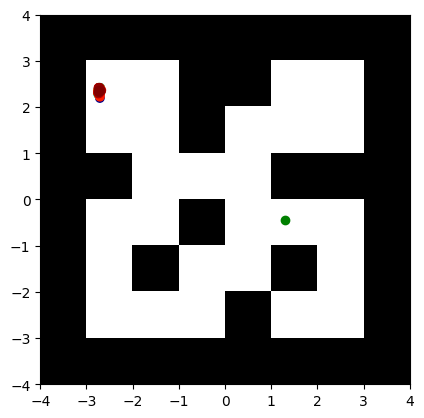

Saved 1 samples to: saved/sample-560-0.png
(1, 257, 4)
1
The last observation [-2.7291358   2.3480215   0.18886375  0.13269794]


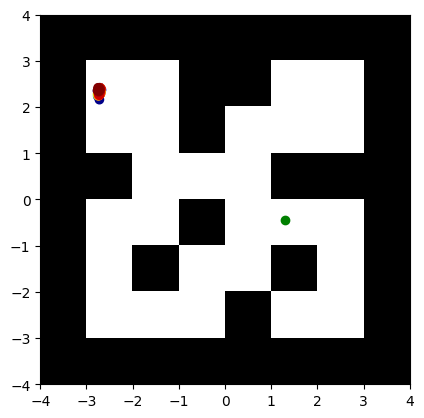

Saved 1 samples to: saved/sample-560-1.png
Step: 570 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7143207   2.362122   -0.12614441  0.17035758]


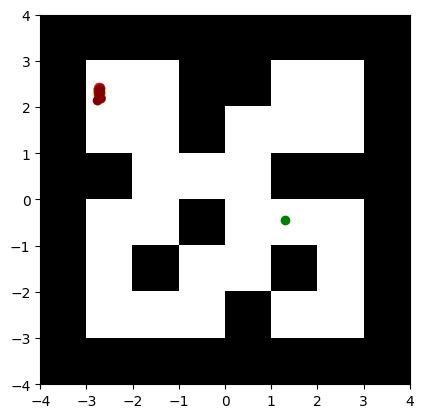

Saved 1 samples to: saved/sample-570-0.png
(1, 257, 4)
1
The last observation [-2.706843    2.3624206  -0.01818991 -0.27853215]


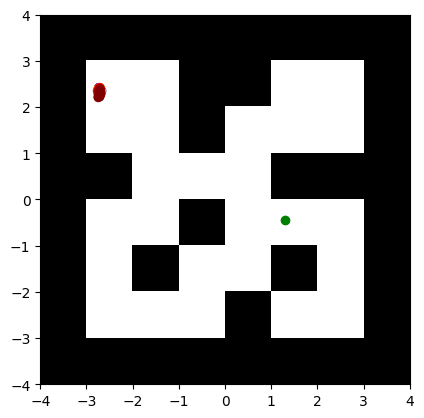

Saved 1 samples to: saved/sample-570-1.png
Step: 580 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7075675   2.3528738  -0.28821492  0.06158721]


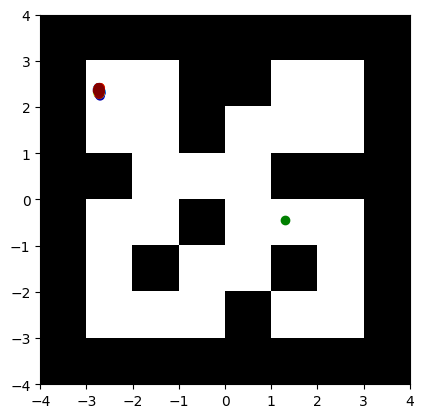

Saved 1 samples to: saved/sample-580-0.png
(1, 257, 4)
1
The last observation [-2.7167776   2.3605647   0.205513    0.16564548]


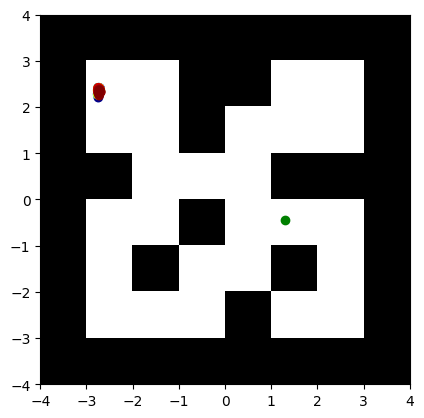

Saved 1 samples to: saved/sample-580-1.png
Step: 590 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7170722   2.378913   -0.10323668 -0.02045059]


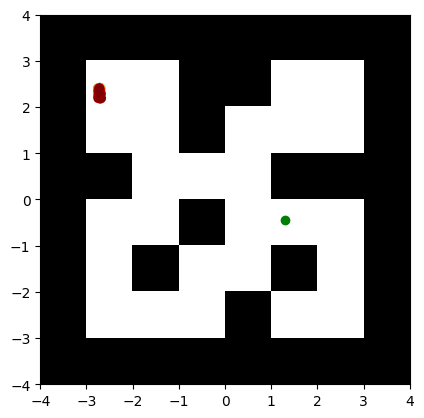

Saved 1 samples to: saved/sample-590-0.png
(1, 257, 4)
1
The last observation [-2.7489762   2.3393102  -0.23282003 -0.02406895]


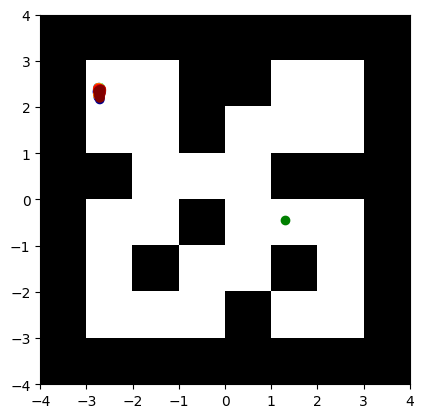

Saved 1 samples to: saved/sample-590-1.png
[ utils/training ] Saved model to saved/state_400.pt
600:   0.0272 | a0_loss:   0.1861 | t: 786.5560
Step: 600 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7223752   2.3724275  -0.2901113  -0.07964873]


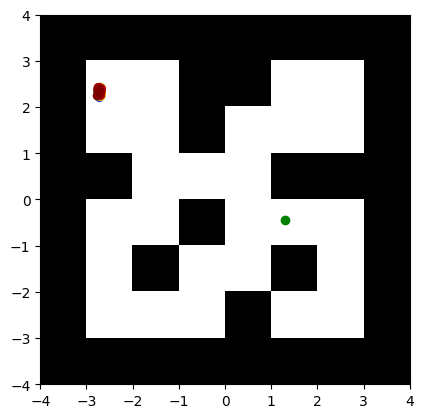

Saved 1 samples to: saved/sample-600-0.png
(1, 257, 4)
1
The last observation [-2.7140224   2.3529334  -0.26477695 -0.21827781]


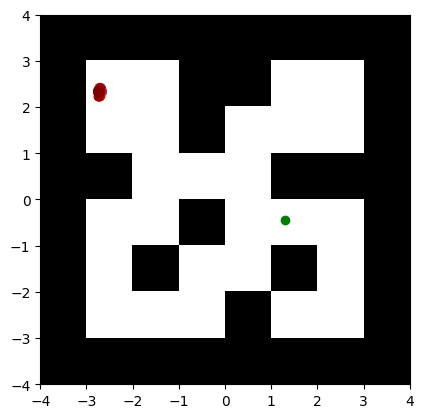

Saved 1 samples to: saved/sample-600-1.png
Step: 610 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7239397   2.366706   -0.14252663  0.12728035]


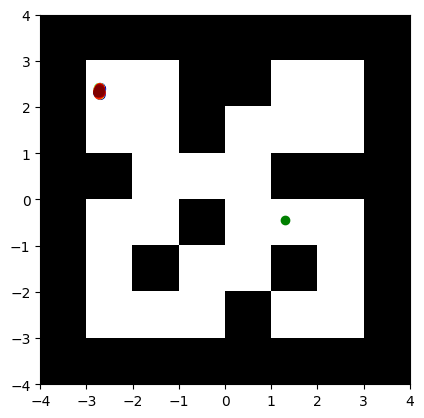

Saved 1 samples to: saved/sample-610-0.png
(1, 257, 4)
1
The last observation [-2.7231553   2.3613944   0.07029724  0.22514045]


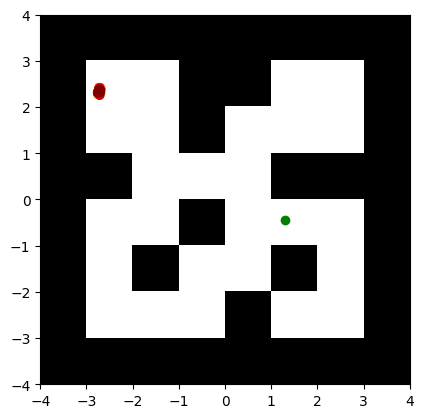

Saved 1 samples to: saved/sample-610-1.png
Step: 620 - Rendering samples
(1, 257, 4)
1
The last observation [-2.715916    2.3738308  -0.13270187 -0.01608527]


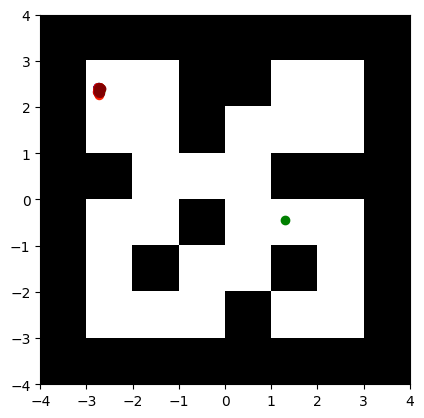

Saved 1 samples to: saved/sample-620-0.png
(1, 257, 4)
1
The last observation [-2.7193575   2.337038   -0.0629549   0.02203584]


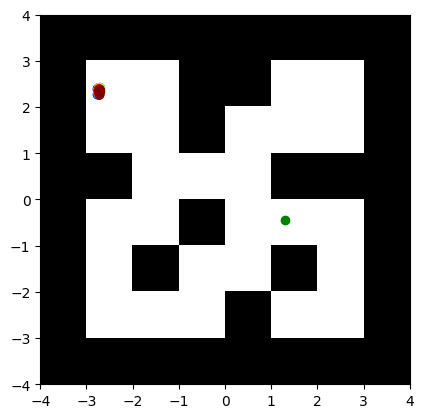

Saved 1 samples to: saved/sample-620-1.png
Step: 630 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7200994   2.3671575  -0.10190678  0.5280477 ]


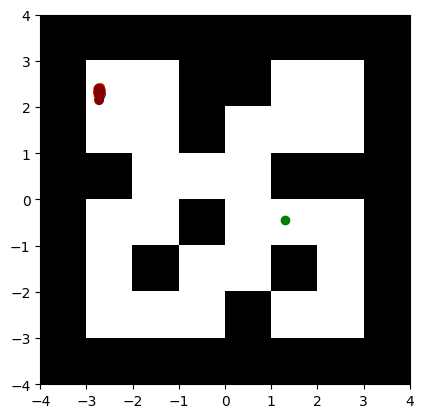

Saved 1 samples to: saved/sample-630-0.png
(1, 257, 4)
1
The last observation [-2.709877    2.3680248  -0.04306841  0.02741492]


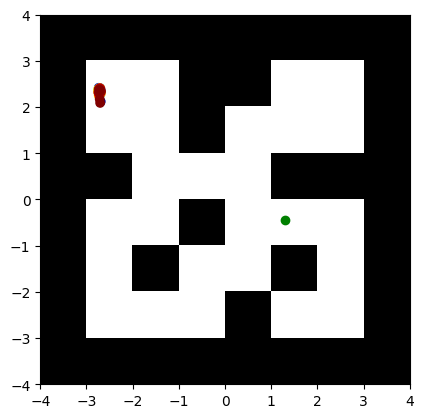

Saved 1 samples to: saved/sample-630-1.png
Step: 640 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7250335   2.3609476   0.14614868 -0.02997041]


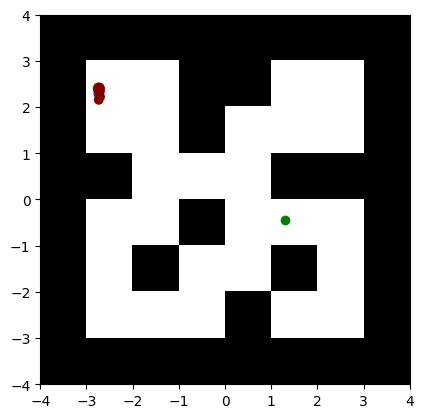

Saved 1 samples to: saved/sample-640-0.png
(1, 257, 4)
1
The last observation [-2.725852    2.34587     0.27885008 -0.11932003]


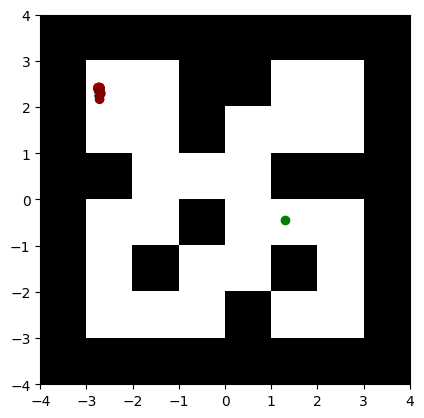

Saved 1 samples to: saved/sample-640-1.png
[ utils/training ] Saved model to saved/state_400.pt
Step: 650 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7217982   2.3654609  -0.08957529 -0.15877724]


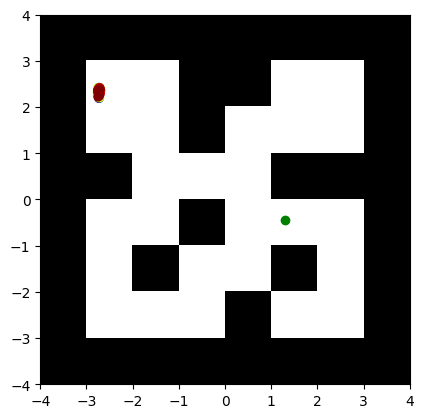

Saved 1 samples to: saved/sample-650-0.png
(1, 257, 4)
1
The last observation [-2.7270577   2.3811111  -0.19381762  0.04048073]


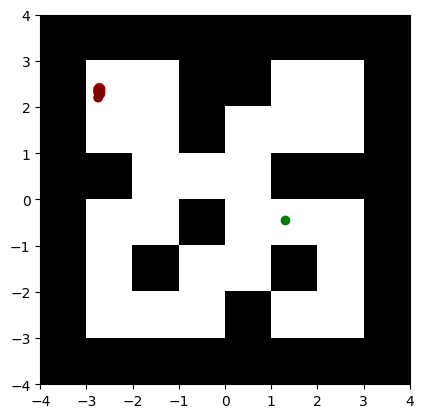

Saved 1 samples to: saved/sample-650-1.png
Step: 660 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7268636   2.3771892  -0.32582188  0.23269284]


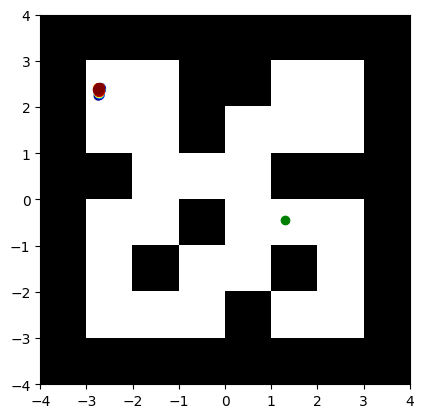

Saved 1 samples to: saved/sample-660-0.png
(1, 257, 4)
1
The last observation [-2.7159483   2.3689003   0.08245945  0.17767894]


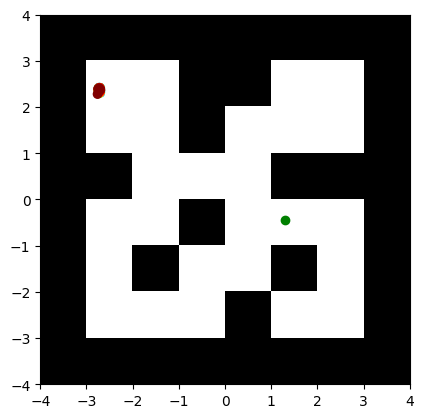

Saved 1 samples to: saved/sample-660-1.png
Step: 670 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7384753   2.362585   -0.11937189 -0.16172469]


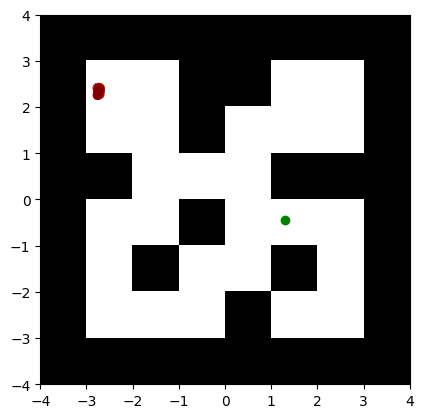

Saved 1 samples to: saved/sample-670-0.png
(1, 257, 4)
1
The last observation [-2.738438    2.3530164   0.01946115 -0.17261589]


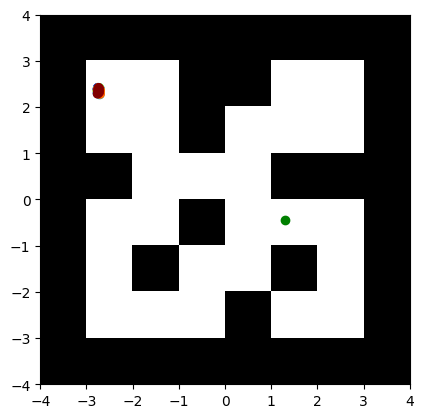

Saved 1 samples to: saved/sample-670-1.png
Step: 680 - Rendering samples
(1, 257, 4)
1
The last observation [-2.746518    2.3639402   0.04040909 -0.24481022]


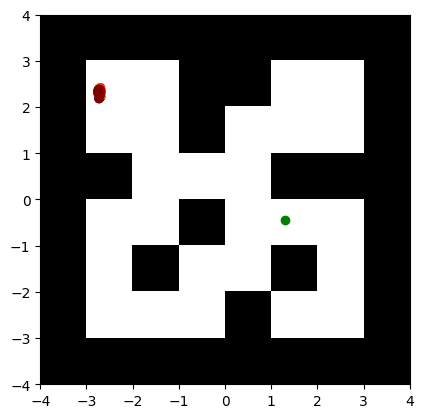

Saved 1 samples to: saved/sample-680-0.png
(1, 257, 4)
1
The last observation [-2.7434063   2.3778305  -0.15650368 -0.12114573]


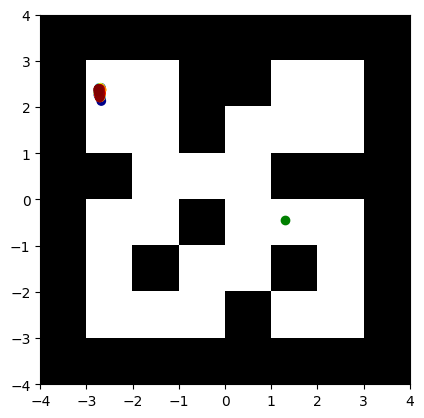

Saved 1 samples to: saved/sample-680-1.png
Step: 690 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7205207   2.3590136  -0.05547237  0.1165632 ]


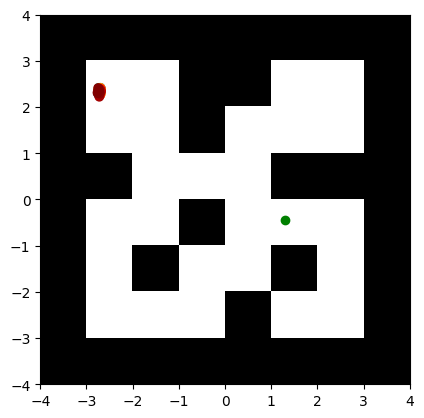

Saved 1 samples to: saved/sample-690-0.png
(1, 257, 4)
1
The last observation [-2.7253308   2.3565178   0.0979023   0.19457614]


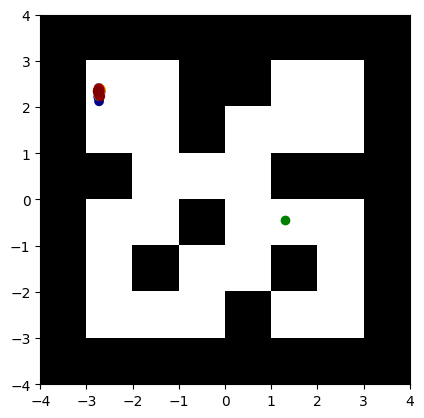

Saved 1 samples to: saved/sample-690-1.png
[ utils/training ] Saved model to saved/state_400.pt
700:   0.0327 | a0_loss:   0.1923 | t: 775.0908
Step: 700 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7314098   2.3481603   0.21769619 -0.16776979]


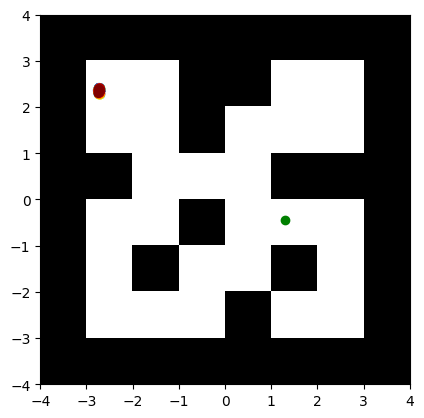

Saved 1 samples to: saved/sample-700-0.png
(1, 257, 4)
1
The last observation [-2.7296717   2.373561    0.13143826  0.2950815 ]


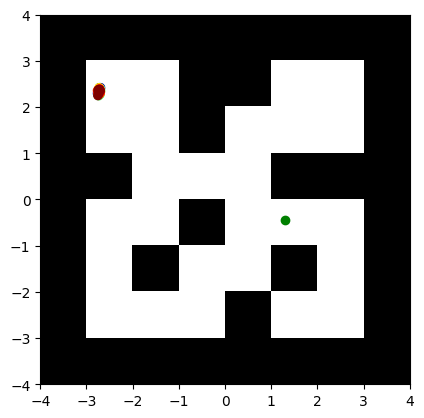

Saved 1 samples to: saved/sample-700-1.png
Step: 710 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7281039   2.361484   -0.07317781 -0.13491082]


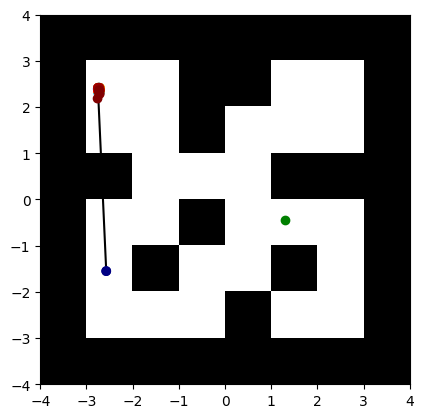

Saved 1 samples to: saved/sample-710-0.png
(1, 257, 4)
1
The last observation [-2.729993    2.3485837  -0.15486526  0.14388883]


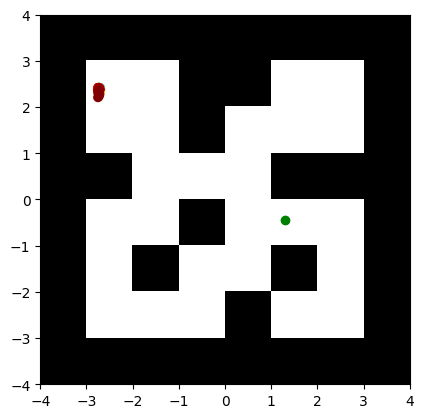

Saved 1 samples to: saved/sample-710-1.png
Step: 720 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7233043   2.387302    0.15433073  0.30325282]


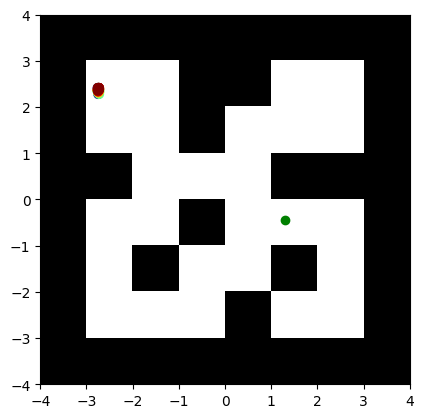

Saved 1 samples to: saved/sample-720-0.png
(1, 257, 4)
1
The last observation [-2.7319763   2.3643937   0.00407887  0.05706322]


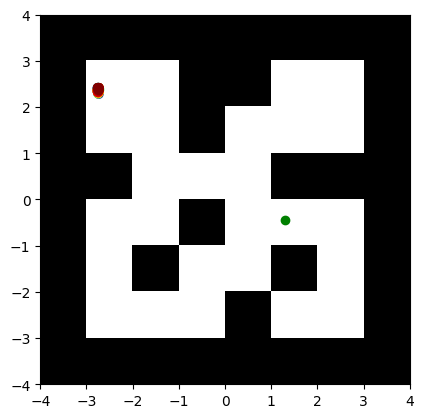

Saved 1 samples to: saved/sample-720-1.png
Step: 730 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7446349   2.3888626   0.34453058  0.09058607]


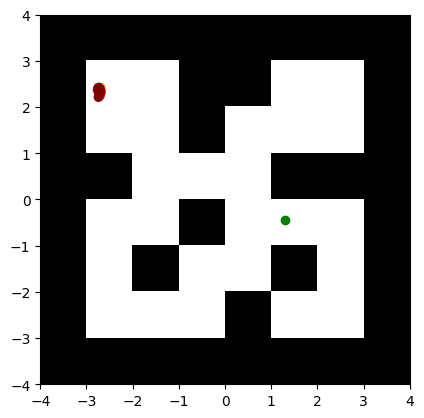

Saved 1 samples to: saved/sample-730-0.png
(1, 257, 4)
1
The last observation [-2.730601    2.358531    0.19947386  0.12851799]


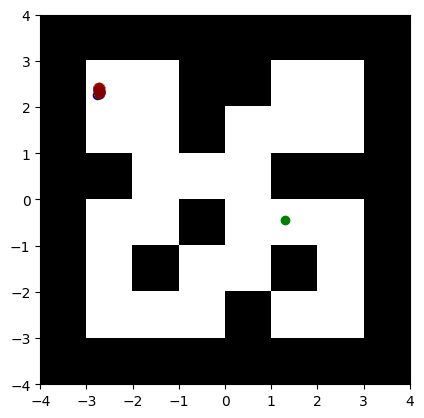

Saved 1 samples to: saved/sample-730-1.png
Step: 740 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7318842   2.3570561   0.15204048  0.14023244]


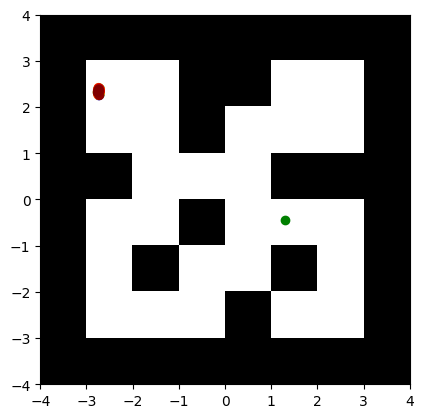

Saved 1 samples to: saved/sample-740-0.png
(1, 257, 4)
1
The last observation [-2.734855    2.377246   -0.11186266  0.11682141]


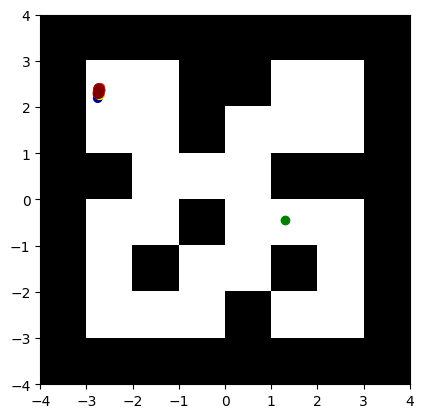

Saved 1 samples to: saved/sample-740-1.png
[ utils/training ] Saved model to saved/state_400.pt
Step: 750 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7296484   2.3619761  -0.12078333  0.07260668]


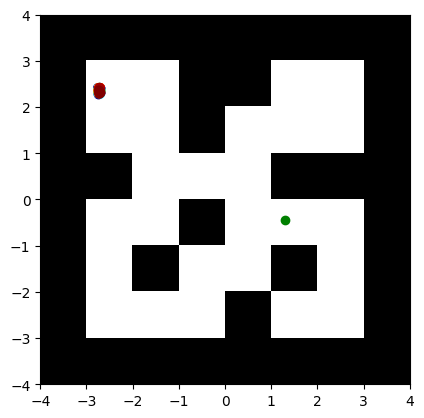

Saved 1 samples to: saved/sample-750-0.png
(1, 257, 4)
1
The last observation [-2.719585    2.3643804  -0.2952454   0.03436673]


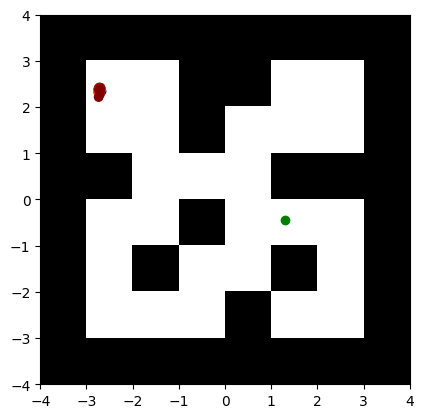

Saved 1 samples to: saved/sample-750-1.png
Step: 760 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7379067   2.36165    -0.30558968 -0.46099377]


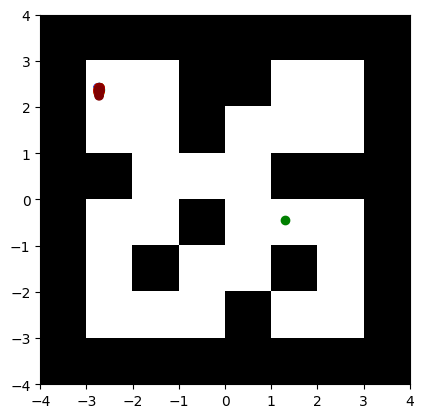

Saved 1 samples to: saved/sample-760-0.png
(1, 257, 4)
1
The last observation [-2.7343717   2.3519197   0.03629255 -0.13692713]


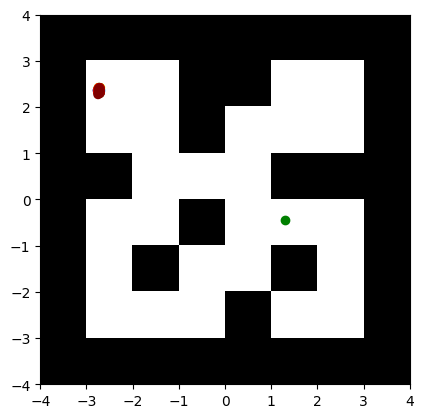

Saved 1 samples to: saved/sample-760-1.png
Step: 770 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7230594   2.370504   -0.10036135  0.23697984]


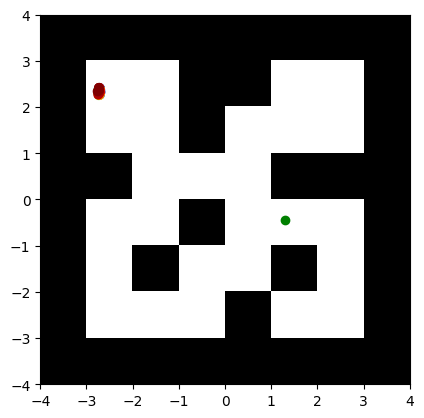

Saved 1 samples to: saved/sample-770-0.png
(1, 257, 4)
1
The last observation [-2.7253118   2.3766322  -0.15834856 -0.17931497]


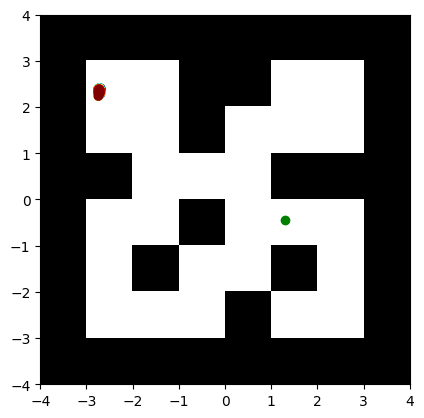

Saved 1 samples to: saved/sample-770-1.png
Step: 780 - Rendering samples
(1, 257, 4)
1
The last observation [-2.7416492   2.381072   -0.05820227  0.0310446 ]


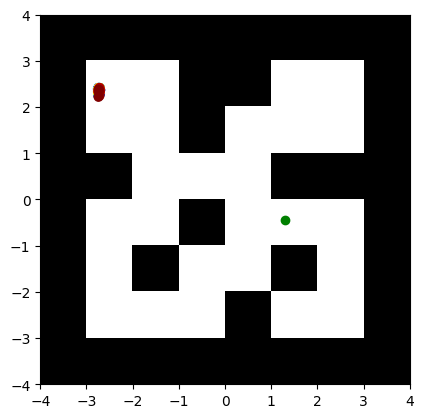

Saved 1 samples to: saved/sample-780-0.png
(1, 257, 4)
1
The last observation [-2.7272968   2.3611937   0.01115179  0.05681241]


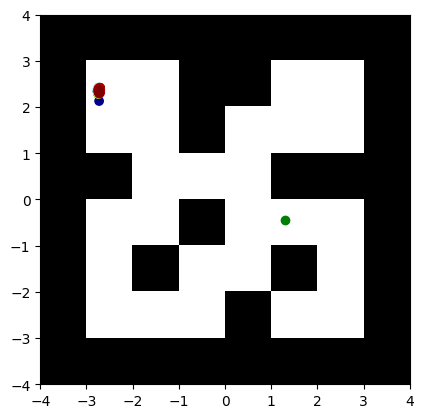

Saved 1 samples to: saved/sample-780-1.png
Step: 790 - Rendering samples
(1, 257, 4)
1
The last observation [-2.716147    2.3733659  -0.09917259  0.09863579]


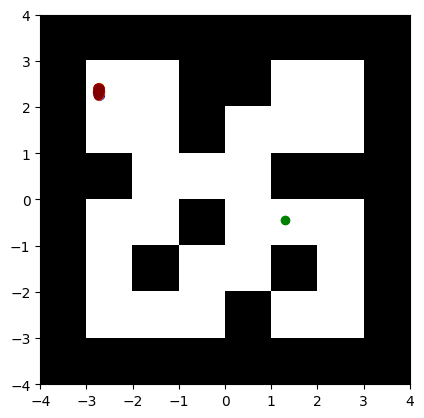

Saved 1 samples to: saved/sample-790-0.png
(1, 257, 4)
1
The last observation [-2.7281234   2.3549666  -0.33406186 -0.3427497 ]


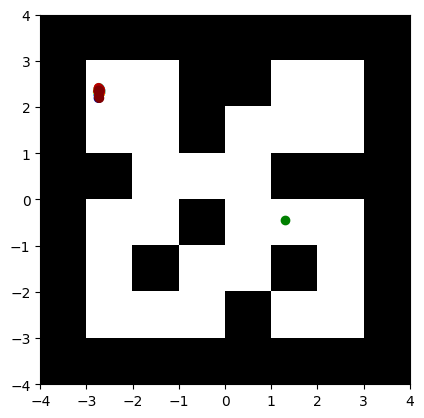

Saved 1 samples to: saved/sample-790-1.png


In [28]:
# n_epochs = int(args.n_train_steps // args.n_steps_per_epoch)
n_epochs = 1
for i in range(n_epochs):
    print(f"Epoch {i} / {n_epochs} | {args.savepath}")
    trainer.train(n_train_steps=500)

## Random Test (don't run)

In [4]:
from contextlib import (
    contextmanager,
    redirect_stderr,
    redirect_stdout,
)


@contextmanager
def suppress_output():
    """
    A context manager that redirects stdout and stderr to devnull
    https://stackoverflow.com/a/52442331
    """
    with open(os.devnull, "w") as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)


# with suppress_output():
#     ## d4rl prints out a variety of warnings
#     import d4rl

# -----------------------------------------------------------------------------#
# -------------------------------- general api --------------------------------#
# -----------------------------------------------------------------------------#


def load_environment(name):
    print(name)
    if type(name) != str:
        # name is already an environment
        return name
    with suppress_output():
        wrapped_env = gym.make(name)
    env = wrapped_env.unwrapped
    env.max_episode_steps = wrapped_env._max_episode_steps
    env.name = name
    return env


class PointMazeStepDataCallback(StepDataCallback):
    """Add environment state information to 'infos'.

    Also, since the environment generates a new target every time it reaches a goal, the environment is
    never terminated or truncated. This callback overrides the truncation value to True when the step
    returns a True 'succes' key in 'infos'. This way we can divide the Minari dataset into different trajectories.
    """

    def __call__(
        self, env, obs, info, action=None, rew=None, terminated=None, truncated=None
    ):
        qpos = obs["observation"][:2]
        qvel = obs["observation"][2:]
        goal = obs["desired_goal"]

        step_data = super().__call__(env, obs, info, action, rew, terminated, truncated)

        if step_data["infos"]["success"]:
            step_data["truncation"] = True
        step_data["infos"]["qpos"] = qpos
        step_data["infos"]["qvel"] = qvel
        step_data["infos"]["goal"] = goal

        return step_data


UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3

EXPLORATION_ACTIONS = {UP: (0, 1), DOWN: (0, -1), LEFT: (-1, 0), RIGHT: (1, 0)}


class QIteration:
    """Solves for optimal policy with Q-Value Iteration.

    Inspired by https://github.com/Farama-Foundation/D4RL/blob/master/d4rl/pointmaze/q_iteration.py
    """

    def __init__(self, maze):
        self.maze = maze
        self.num_states = maze.map_length * maze.map_width
        self.num_actions = len(EXPLORATION_ACTIONS.keys())
        self.rew_matrix = np.zeros((self.num_states, self.num_actions))
        self.compute_transition_matrix()

    def generate_path(self, current_cell, goal_cell):
        self.compute_reward_matrix(goal_cell)
        q_values = self.get_q_values()
        current_state = self.cell_to_state(current_cell)
        waypoints = {}
        while True:
            action_id = np.argmax(q_values[current_state])
            next_state, _ = self.get_next_state(
                current_state, EXPLORATION_ACTIONS[action_id]
            )
            current_cell = self.state_to_cell(current_state)
            waypoints[current_cell] = self.state_to_cell(next_state)
            if waypoints[current_cell] == goal_cell:
                break

            current_state = next_state

        return waypoints

    def reward_function(self, desired_cell, current_cell):
        if desired_cell == current_cell:
            return 1.0
        else:
            return 0.0

    def state_to_cell(self, state):
        i = int(state / self.maze.map_width)
        j = state % self.maze.map_width
        return (i, j)

    def cell_to_state(self, cell):
        return cell[0] * self.maze.map_width + cell[1]

    def get_q_values(self, num_itrs=50, discount=0.99):
        q_fn = np.zeros((self.num_states, self.num_actions))
        for _ in range(num_itrs):
            v_fn = np.max(q_fn, axis=1)
            q_fn = self.rew_matrix + discount * self.transition_matrix.dot(v_fn)
        return q_fn

    def compute_reward_matrix(self, goal_cell):
        for state in range(self.num_states):
            for action in range(self.num_actions):
                next_state, _ = self.get_next_state(state, EXPLORATION_ACTIONS[action])
                next_cell = self.state_to_cell(next_state)
                self.rew_matrix[state, action] = self.reward_function(
                    goal_cell, next_cell
                )

    def compute_transition_matrix(self):
        """Constructs this environment's transition matrix.
        Returns:
          A dS x dA x dS array where the entry transition_matrix[s, a, ns]
          corresponds to the probability of transitioning into state ns after taking
          action a from state s.
        """
        self.transition_matrix = np.zeros(
            (self.num_states, self.num_actions, self.num_states)
        )
        for state in range(self.num_states):
            for action_idx, action in EXPLORATION_ACTIONS.items():
                next_state, valid = self.get_next_state(state, action)
                if valid:
                    self.transition_matrix[state, action_idx, next_state] = 1

    def get_next_state(self, state, action):
        cell = self.state_to_cell(state)

        next_cell = tuple(map(lambda i, j: int(i + j), cell, action))
        next_state = self.cell_to_state(next_cell)

        return next_state, self._check_valid_cell(next_cell)

    def _check_valid_cell(self, cell):
        # Out of map bounds
        if cell[0] >= self.maze.map_length:
            return False
        elif cell[1] >= self.maze.map_width:
            return False
        # Wall collision
        elif self.maze.maze_map[cell[0]][cell[1]] == 1:
            return False
        else:
            return True


class WaypointController:
    """Agent controller to follow waypoints in the maze.

    Inspired by https://github.com/Farama-Foundation/D4RL/blob/master/d4rl/pointmaze/waypoint_controller.py
    """

    def __init__(self, maze, gains={"p": 10.0, "d": -1.0}, waypoint_threshold=0.1):
        self.global_target_xy = np.empty(2)
        self.maze = maze

        self.maze_solver = QIteration(maze=self.maze)

        self.gains = gains
        self.waypoint_threshold = waypoint_threshold
        self.waypoint_targets = None

    def compute_action(self, obs):
        # Check if we need to generate new waypoint path due to change in global target
        if (
            np.linalg.norm(self.global_target_xy - obs["desired_goal"]) > 1e-3
            or self.waypoint_targets is None
        ):
            # Convert xy to cell id
            achieved_goal_cell = tuple(
                self.maze.cell_xy_to_rowcol(obs["achieved_goal"])
            )
            self.global_target_id = tuple(
                self.maze.cell_xy_to_rowcol(obs["desired_goal"])
            )
            self.global_target_xy = obs["desired_goal"]

            self.waypoint_targets = self.maze_solver.generate_path(
                achieved_goal_cell, self.global_target_id
            )

            # Check if the waypoint dictionary is empty
            # If empty then the ball is already in the target cell location
            if self.waypoint_targets:
                self.current_control_target_id = self.waypoint_targets[
                    achieved_goal_cell
                ]
                self.current_control_target_xy = self.maze.cell_rowcol_to_xy(
                    np.array(self.current_control_target_id)
                )
            else:
                self.waypoint_targets[self.current_control_target_id] = (
                    self.current_control_target_id
                )
                self.current_control_target_id = self.global_target_id
                self.current_control_target_xy = self.global_target_xy

        # Check if we need to go to the next waypoint
        dist = np.linalg.norm(self.current_control_target_xy - obs["achieved_goal"])
        if (
            dist <= self.waypoint_threshold
            and self.current_control_target_id != self.global_target_id
        ):
            self.current_control_target_id = self.waypoint_targets[
                self.current_control_target_id
            ]
            # If target is global goal go directly to goal position
            if self.current_control_target_id == self.global_target_id:
                self.current_control_target_xy = self.global_target_xy
            else:
                self.current_control_target_xy = (
                    self.maze.cell_rowcol_to_xy(
                        np.array(self.current_control_target_id)
                    )
                    - np.random.uniform(size=(2,)) * 0.2
                )

        action = (
            self.gains["p"] * (self.current_control_target_xy - obs["achieved_goal"])
            + self.gains["d"] * obs["observation"][2:]
        )
        action = np.clip(action, -1, 1)

        return action


def get_dataset():
    # Code from Minari documentation
    dataset_name = "pointmaze-umaze-v0"
    total_steps = 1000

    # continuing task => the episode doesn't terminate or truncate when reaching a goal
    # it will generate a new target. For this reason we set the maximum episode steps to
    # the desired size of our Minari dataset (evade truncation due to time limit)
    env = gym.make(
        "PointMaze_Medium-v3", continuing_task=True, max_episode_steps=total_steps // 2
    )

    # Data collector wrapper to save temporary data while stepping. Characteristics:
    #   * Custom StepDataCallback to add extra state information to 'infos' and divide dataset in different episodes by overridng
    #     truncation value to True when target is reached
    #   * Record the 'info' value of every step
    collector_env = DataCollector(
        env, step_data_callback=PointMazeStepDataCallback, record_infos=True
    )

    obs, _ = collector_env.reset(seed=123)

    waypoint_controller = WaypointController(maze=env.maze)

    for n_step in range(int(total_steps)):
        action = waypoint_controller.compute_action(obs)
        # Add some noise to each step action
        action += np.random.randn(*action.shape) * 0.5
        action = np.clip(
            action, env.action_space.low, env.action_space.high, dtype=np.float32
        )

        obs, rew, terminated, truncated, info = collector_env.step(action)

    dataset = collector_env.create_dataset(
        dataset_id=dataset_name,
        algorithm_name="QIteration",
        code_permalink="https://github.com/Farama-Foundation/Minari/blob/main/docs/tutorials/dataset_creation/point_maze_dataset.py",
        author="Rodrigo Perez-Vicente",
        author_email="rperezvicente@farama.org",
    )
    return dataset


dataset = get_dataset()

c:\Users\Beste Aydemir\AppData\Local\pypoetry\Cache\virtualenvs\adlr-uQXv-DS1-py3.10\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.maze to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.maze` for environment variables or `env.get_wrapper_attr('maze')` that will search the reminding wrappers.
  logger.warn(


ValueError: A Minari dataset with ID pointmaze-umaze-v0 already exists and it cannot be overridden. Please use a different dataset name or version.

In [ ]:
print(dataset)
print(dataset["actions"])

In [ ]:
reshaped = {}
for key, val in dataset.items():
    dim = val.shape[-1]
    reshaped[key] = val.reshape(-1, dim)

In [ ]:
def process_maze2d_episode(episode):
    '''
        adds in `next_observations` field to episode
    '''
    #assert 'next_observations' not in episode
    ep = {}
    length = len(episode.observations)
    next_observations = episode.observations["observation"][1:].copy()
    for key, val in episode.observations.items():
        ep[key] = val[:-1]
    ep['next_observations'] = next_observations
    for attr, value in vars(episode).items():
      if attr == "observations":
        continue
      elif attr == "terminations":
        ep["terminals"] = value
      elif attr == "truncations":
        ep["timeouts"] = value
      elif attr == "id" or attr == "seed" or attr == "total_timesteps" or "infos"
        continue
      else:
        ep[attr] = value

    return ep

In [ ]:
a = process_maze2d_episode(dataset[0])

In [ ]:
print(a.keys())

In [ ]:
a["terminals"].any()

In [ ]:
dataset[0].infos["goal"].shape

In [ ]:
for attr, value in vars(dataset[0]).items():
    if attr == "observations":
        continue
    print(f"{attr}: {value}")

In [ ]:
# dataset = get_dataset()
# dataset = preprocess_fn(dataset)

# N = dataset['rewards'].shape[0]
N = dataset[0].rewards.shape[0]
# N = dataset._data.total_episodes
data_ = collections.defaultdict(list)

# The newer version of the dataset adds an explicit
# timeouts field. Keep old method for backwards compatability.
use_timeouts = False
print(N)
episode_step = 0
for i in range(N):
    # print(dataset[i])
    # dataset[i].observations
    # done_bool = bool(dataset['terminals'][i])
    done_bool = bool(dataset[episode_step].terminations[i])

    final_timestep = episode_step == env._max_episode_steps - 1

    # for k in dataset:
    for attr, value in vars(dataset[episode_step]).items():
        # if 'metadata' in k: continue
        # data_[k].append(dataset[k][i])
        data_[attr].append(value)

    if done_bool or final_timestep:
        episode_step = 0
        episode_data = {}
        for k in data_:
            episode_data[k] = np.array(data_[k])
        episode_data = process_maze2d_episode(dataset[i])
        print(episode_data)
        data_ = collections.defaultdict(list)

        episode_step += 1
    break